### Import's

In [23]:
import pandas as pd
import statistics
from collections import Counter
import matplotlib.pyplot as plt
import json

### Lendo arquivo csv

In [81]:
## Ler o arquivo csv, e ler apenas as colunas ['Palavras', 'Rotulo', 'Sentenca']
## df_original = pd.read_csv("./Divergencias.csv", usecols=['Palavras', 'Rotulo', 'Sentenca'])
df_original = pd.read_csv("./Dataset_Padrao_IOB_Versao4.csv", usecols=['Palavras', 'Rotulo', 'Sentenca'], encoding='utf-8-sig')

In [86]:
display(df_original)

,Palavras,Rotulo,Sentenca
0,id,O,1
1,:,O,1
2,0,O,1
3,NOME,O,2
4,DA,O,2
...,...,...,...
186014,Destilados,O,14628
186015,do,O,14628
186016,Brasil,B-NOME_LOCAL,14628
186017,2019,B-TEMPO,14628


#### Visualizando os tipos do elementos no DataFrame

In [26]:
display(df_original.dtypes)

Palavras    object
Rotulo      object
Sentenca     int64
dtype: object

In [27]:
display(df_original.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186019 entries, 0 to 186018
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Palavras  186019 non-null  object
 1   Rotulo    186019 non-null  object
 2   Sentenca  186019 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.3+ MB


None

### Filtrando e pegando as informações de instâncias
OBS: 
- Está parte é Facultativa pode-se utilizar de arquivos já gerados a partir desta etapa, pula para etapa "Salvando/Lendo o DataFrame df_limpa"
- Os dados a serem descartados são o "id", por ser apenas uma referência, e não faz parte dos dados propriamente ditos, e os  sinais de pontuação na contagem. (As motivações para retirar esses dados não couberam ao desenvolvedor)

#### Inicializando as variaveis
Essas variaveis ajudarão na construção das estatisticas!

In [28]:
index_remove = []
lista_tokens_por_inst = [] ## Lista para armazenar tokens por instâncias
cont_tokens = 0
lista_sentencas_por_inst_original = [[0,0]] ## Lista para armazenar tokens por instâncias, com valor presetado (o padrão é [<sentença atual>,<qtd de senteças>])
lista_rotulacoes_por_inst_IOB = []
dict_rotulacoes = dict({})

#### Filtrando
Lembrete sempre execute a cedula de cima antes!

In [29]:
for index, dado in df_original.iterrows():
    try:
        if (len(dado['Palavras']) == 1 and not dado['Palavras'][0].isalnum()) and dado["Rotulo"] == 'O': ## Retirar os caracteres especiais que estão sozinhos
            index_remove.append(index)
        elif (dado['Palavras'] == 'id'): ## Retirar o id e o número que o acompanha
            index_remove.append(index)
            index_remove.append(index + 2) ## Para pegar o número do id
            lista_tokens_por_inst.append(cont_tokens) ## Adiciona os token's calculados do id anterior na lista
            cont_tokens = 0 ## Zera o contador para iniciar uma nova contagem de tokens por instância
            lista_sentencas_por_inst_original.append([0,0]) ## Inicio outra contagem de sentença por instância
            lista_rotulacoes_por_inst_IOB.append(list(dict_rotulacoes.items()))
            dict_rotulacoes = dict({})
        elif index not in index_remove:
            if dado['Sentenca'] != lista_sentencas_por_inst_original[-1][0]: ## Vejo se estou mexendo com outra sentença, caso se atualizo a sentença atual e adiciono um ao contador
                lista_sentencas_por_inst_original[-1][0] = dado['Sentenca']
                lista_sentencas_por_inst_original[-1][1] += 1
            if dado['Rotulo'] not in dict_rotulacoes.keys():
                dict_rotulacoes.update(dict({dado['Rotulo'] : 0}))
            dict_rotulacoes[dado['Rotulo']] += 1
            cont_tokens += 1 ## Incrementa um token ao contador, visto de ser um token considerado válido
    except:
        print("Houve erro na palavra: " + str(dado['Palavra']))
        break

#### Arrumando os dados das variveis

In [30]:
## Comandos para adequar as variveis para realização das estatisticas
lista_tokens_por_inst.append(cont_tokens) ## Adiciona os token's calculados do id último
lista_tokens_por_inst.pop(0) ## Retiro primeiro elemento da lista por ser um elemento sempre 0
lista_sentencas_por_inst_original.pop(0) ## Retiro primeiro elemento da lista por ser um elemento sem valor
lista_rotulacoes_por_inst_IOB.append(list(dict_rotulacoes.items()))
lista_rotulacoes_por_inst_IOB.pop(0)

[]

#### Retirando os elementos não desejados do DF original

In [31]:
df_limpa = df_original.drop(axis=0, index=index_remove)

In [32]:
display(df_limpa)

,Palavras,Rotulo,Sentenca
3,NOME,O,2
4,DA,O,2
5,CACHAÇA,O,2
7,Cachaça,O,2
8,Três,B-NOME_BEBIDA,2
...,...,...,...
186013,e,O,14628
186014,Destilados,O,14628
186015,do,O,14628
186016,Brasil,B-NOME_LOCAL,14628


### Salvando/Lendo o DataFrame df_limpa
A df_limpa é salva devido que é apenas obtida após percorrer todo o df_original, o que demanda bastante tempo, então afim de agilizar, se salva e ler a df_limpa.

#### Salvando

In [33]:
df_limpa.to_csv("./Dados_Auxiliares/Dataset_Padrao_IOB_Versao4_Limpo.csv", encoding='utf-8-sig')

#### Lendo

In [34]:
df_limpa = pd.read_csv("./Dados_Auxiliares/Dataset_Padrao_IOB_Versao4_Limpo.csv", encoding='utf-8-sig')

### Salvando/Lendo os dados que não utilizam do df_limpa para serem gerados
Os dados aqui são salvos pq só são possiveis obter quando percorremos o df_original e para isso demanda bastante tempo de codigo e para agilizar aqui fica salvo esses dados

#### Salvando

In [35]:
## Salvando as informações de tokens por instância
with open('./Dados_Auxiliares/lista_tokens_por_inst.json', 'w') as arquivo:
    json.dump(lista_tokens_por_inst, arquivo)

## Salvando as informações de setenças por instância
with open('./Dados_Auxiliares/lista_sentencas_por_inst_original.json', 'w') as arquivo:
    json.dump(lista_sentencas_por_inst_original, arquivo)

## Salvando as informações de rotulos por instância
with open('./Dados_Auxiliares/lista_rotulacoes_por_inst_IOB.json', 'w') as arquivo:
    json.dump(lista_rotulacoes_por_inst_IOB, arquivo)

#### Lendo

In [36]:
## Lendo as informações de tokens por instância
with open('./Dados_Auxiliares/lista_tokens_por_inst.json', 'r') as arquivo:
    lista_tokens_por_inst = json.load(arquivo)

## Lendo as informações de setenças por instância
with open('./Dados_Auxiliares/lista_sentencas_por_inst_original.json', 'r') as arquivo:
    lista_sentencas_por_inst_original = json.load(arquivo)

## Lendo as informações de rotulos por instância
with open('./Dados_Auxiliares/lista_rotulacoes_por_inst_IOB.json', 'r') as arquivo:
    lista_rotulacoes_por_inst_IOB = json.load(arquivo)

### Preparando / visualizando os dados para a estatística

#### Metodo para retirar IOB
Tem a função de retirar o I-rotulo e B-rotulo para visualização crua dos rotulos

In [37]:
## Função para tirar o IOB das rotulações
def retira_IOB(lista_rotulacoes):
    dict_rotulacoes = dict({})
    for index, dado in enumerate(lista_rotulacoes):
        if dado[0] != 'O':
            if dado[0][2:] not in dict_rotulacoes.keys():
                dict_rotulacoes.update(dict({dado[0][2:] : 0}))
            dict_rotulacoes[dado[0][2:]] += dado[1]
        else:
            dict_rotulacoes[dado[0]] = dado[1]
    return list(dict_rotulacoes.items())

In [38]:
## Preparando para pegar tokens por setença
lista_tokens_por_sentenca = list(df_limpa.groupby(by="Sentenca")["Palavras"].count()) ## Agrupa as sentenças conto quantos tokens tem por setença e transforma em lista
## Preparando para extrair sentenças por instâncias
lista_sentencas_por_inst = [x[1] for x in lista_sentencas_por_inst_original] ## Extrai apenas a quantidade de sentenças presentes por instância
## Preparando para pegar as quantidades de rotulações
lista_qtdRotulacoes_IOB = [[x[0], x[1]["Palavras"].count()] for x in df_limpa.groupby(by="Rotulo")] ## Agrupa por rotulação e calcucula quantos tokens tem por rotulação
## Preparando para pegar as quantidades de rotulações sem IOB
lista_qtdRotulacoes = retira_IOB(lista_qtdRotulacoes_IOB)

In [39]:
## Preparando para pegar rotulações por sentença
lista_rotulos_por_sentenca_IOB = []
for dado in df_limpa.groupby(by="Sentenca"):
    lista_rotulos_por_sentenca_IOB.append([dado[0], list(Counter(list(dado[1]["Rotulo"])).items())])

In [40]:
## Preparando para extrair rotulações por sentença sem IOB
lista_rotulos_por_sentenca = []
for sentenca in lista_rotulos_por_sentenca_IOB:
    lista_rotulos_por_sentenca.append([sentenca[0], retira_IOB(sentenca[1])])

In [41]:
## Preparando para extrair rotulações por instância sem IOB
lista_rotulacoes_por_inst = []
for instancia in lista_rotulacoes_por_inst_IOB:
    lista_rotulacoes_por_inst.append(retira_IOB(instancia))

In [42]:
## Preparando para pegar rotulações por token
lista_rotulacoes_por_tokens_IOB = []
for dado in df_limpa.groupby(by="Palavras"):
    lista_rotulacoes_por_tokens_IOB.append([dado[0], list(Counter(list(dado[1]["Rotulo"])).items())])

In [43]:
lista_rotulacoes_por_tokens = []
for token in lista_rotulacoes_por_tokens_IOB:
    lista_rotulacoes_por_tokens.append([token[0], retira_IOB(token[1])])

In [87]:
## print(lista_tokens_por_sentenca) ## Tokens por sentença

In [45]:
## print(lista_tokens_por_inst) ## Tokens por instâncias

In [46]:
## print(lista_sentencas_por_inst) ## Setenças por instâncias

## Informações da Estatística

In [47]:
print("Quantidade de tokens removidos: " + str(len(df_original) - len(df_limpa)))

Quantidade de tokens removidos: 29996


### Dados demográficos 

In [48]:
print("-----QUANTIDADES-----")
print("Quantidade de instâncias: " + str(len(lista_tokens_por_inst)))
print("Quantidade de sentenças: " + str(len(lista_tokens_por_sentenca)))
print("Quantidade de tokens: " + str(len(df_limpa)))

-----QUANTIDADES-----
Quantidade de instâncias: 1000
Quantidade de sentenças: 13615
Quantidade de tokens: 156023


#### Rotulacoes

##### Qtd totais Rotulações  - Gráficos

In [49]:
## print(lista_qtdRotulacoes_IOB) ## Quantidade de rotulações com IOB

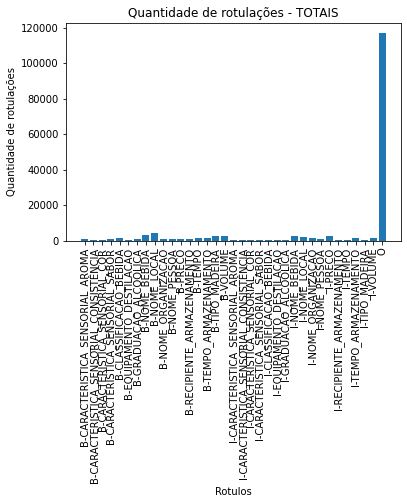

In [50]:
grupos = [x[0] for x in lista_qtdRotulacoes_IOB]
valores = [x[1] for x in lista_qtdRotulacoes_IOB]
plt.bar(grupos, valores)
plt.title('Quantidade de rotulações - TOTAIS')
plt.ylabel('Quantidade de rotulações')
plt.xlabel('Rotulos')
plt.xticks(rotation='vertical')
plt.show()

In [51]:
## print(lista_qtdRotulacoes) ## Quantidade de rotulações

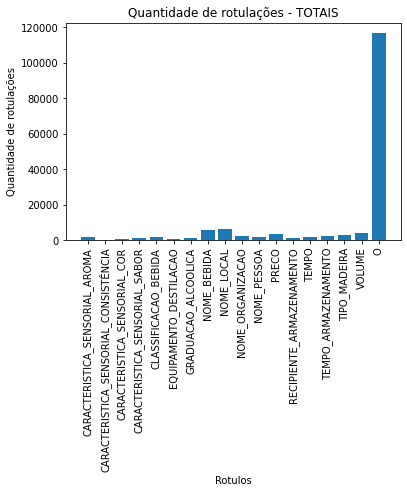

In [52]:
grupos = [x[0] for x in lista_qtdRotulacoes]
valores = [x[1] for x in lista_qtdRotulacoes]
plt.bar(grupos, valores)
plt.title('Quantidade de rotulações - TOTAIS')
plt.ylabel('Quantidade de rotulações')
plt.xlabel('Rotulos')
plt.xticks(rotation='vertical')
plt.show()

In [53]:
## print(lista_rotulos_por_sentenca_IOB) ## Quantidade de rotulações por sentença com IOB

In [54]:
## print(lista_rotulos_por_sentenca) ## Quantidade de rotulações por sentença

In [55]:
## print(lista_rotulacoes_por_inst_IOB) ## Quantidade de rotulação por instância com IOB

In [56]:
## print(lista_rotulacoes_por_inst) ## Quantidade de rotulação por instância

In [57]:
## print(lista_rotulacoes_por_tokens_IOB) ## Quantidade de rotulações por tokens com IOB

In [58]:
## print(lista_rotulacoes_por_tokens) ## Quantidade de rotulações por tokens

### TOKENS POR SENTENÇA

In [59]:
print("-----QUANTIDADES-----")
print("Quantidade de sentenças: " + str(len(lista_tokens_por_sentenca)))
print("Quantidade de tokens: " + str(sum(lista_tokens_por_sentenca)))
print("Quantidade máxima de tokens em uma sentença: " + str(max(lista_tokens_por_sentenca)))
print("Quantidade mínima de tokens em uma sentença: " + str(min(lista_tokens_por_sentenca)))
print("-----Médias-----")
print("Média aritmética dos tokens por sentença: " + str(statistics.mean(lista_tokens_por_sentenca)))
print("Média geométrica dos tokens por sentença: " + str(statistics.geometric_mean(lista_tokens_por_sentenca)))
print("Média harmônica dos tokens por sentença: " + str(statistics.harmonic_mean(lista_tokens_por_sentenca)))
print("-----Medianas-----")
print("Mediana dos tokens por setença: " + str(statistics.median(lista_tokens_por_sentenca)))
print("Mediana inferior dos tokens por setença: " + str(statistics.median_low(lista_tokens_por_sentenca)))
print("Mediana superior dos tokens por setença: " + str(statistics.median_high(lista_tokens_por_sentenca)))
print("Mediana, ou o 50º percentil dos dados agrupados dos tokens por setença: " + str(statistics.median_grouped(lista_tokens_por_sentenca)))
print("-----Moda-----")
print("Moda dos tokens por sentença: " + str(statistics.mode(lista_tokens_por_sentenca)))
print("-----Desvio Padrão-----")
print("Desvio padrão populacional dos tokens por sentença: " + str(statistics.pstdev(lista_tokens_por_sentenca)))
print("Desvio padrão amostral dos tokens por sentença: " + str(statistics.stdev(lista_tokens_por_sentenca)))
print("-----Variância-----")
print("Variância populacional dos tokens por sentença: " + str(statistics.pvariance(lista_tokens_por_sentenca)))
print("Variância amostral dos tokens por sentença: " + str(statistics.variance(lista_tokens_por_sentenca)))
print("-----Quantiles-----")
print("Quantiles dos tokens por sentença: " + str(statistics.quantiles(lista_tokens_por_sentenca)))

-----QUANTIDADES-----
Quantidade de sentenças: 13615
Quantidade de tokens: 156023
Quantidade máxima de tokens em uma sentença: 95
Quantidade mínima de tokens em uma sentença: 1
-----Médias-----
Média aritmética dos tokens por sentença: 11.459640102827764
Média geométrica dos tokens por sentença: 7.659884401338135
Média harmônica dos tokens por sentença: 5.253517240758612
-----Medianas-----
Mediana dos tokens por setença: 7
Mediana inferior dos tokens por setença: 7
Mediana superior dos tokens por setença: 7
Mediana, ou o 50º percentil dos dados agrupados dos tokens por setença: 7.25686591276252
-----Moda-----
Moda dos tokens por sentença: 3
-----Desvio Padrão-----
Desvio padrão populacional dos tokens por sentença: 10.962894624858329
Desvio padrão amostral dos tokens por sentença: 10.963297250586097
-----Variância-----
Variância populacional dos tokens por sentença: 120.18505855574763
Variância amostral dos tokens por sentença: 120.19388660470868
-----Quantiles-----
Quantiles dos token

#### Gráficos

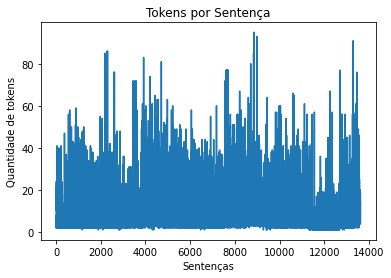

In [60]:
plt.plot([x for x in range(len(lista_tokens_por_sentenca))], lista_tokens_por_sentenca)
plt.title("Tokens por Sentença")
plt.ylabel('Quantidade de tokens')
plt.xlabel('Sentenças')
plt.show()

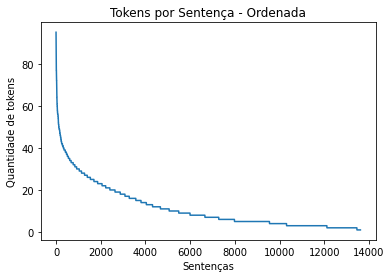

In [61]:
plt.plot([x for x in range(len(lista_tokens_por_sentenca))], sorted(lista_tokens_por_sentenca, reverse=True))
plt.title("Tokens por Sentença - Ordenada")
plt.ylabel('Quantidade de tokens')
plt.xlabel('Sentenças')
plt.show()

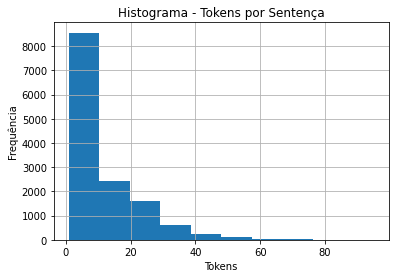

In [62]:
plt.hist(lista_tokens_por_sentenca)
plt.xlabel('Tokens')
plt.ylabel('Frequência')
plt.title('Histograma - Tokens por Sentença')
plt.grid()
plt.show()

### TOKENS POR INSTÂNCIA

In [63]:
print("-----QUANTIDADES-----")
print("Quantidade de instâncias: " + str(len(lista_tokens_por_inst)))
print("Quantidade de tokens: " + str(sum(lista_tokens_por_inst)))
print("Quantidade máxima de tokens em uma instância: " + str(max(lista_tokens_por_inst)))
print("Quantidade mínima de tokens em uma instância: " + str(min(lista_tokens_por_inst)))
print("-----Médias-----")
print("Média aritmética dos tokens por instância: " + str(statistics.mean(lista_tokens_por_inst)))
print("Média geométrica dos tokens por instância: " + str(statistics.geometric_mean(lista_tokens_por_inst)))
print("Média harmônica dos tokens por instância: " + str(statistics.harmonic_mean(lista_tokens_por_inst)))
print("-----Medianas-----")
print("Mediana dos tokens por instância: " + str(statistics.median(lista_tokens_por_inst)))
print("Mediana inferior dos tokens por instância: " + str(statistics.median_low(lista_tokens_por_inst)))
print("Mediana superior dos tokens por instância: " + str(statistics.median_high(lista_tokens_por_inst)))
print("Mediana, ou o 50º percentil dos dados agrupados dos tokens por instância: " + str(statistics.median_grouped(lista_tokens_por_inst)))
print("-----Moda-----")
print("Moda dos tokens por instância: " + str(statistics.mode(lista_tokens_por_inst)))
print("-----Desvio Padrão-----")
print("Desvio padrão populacional dos tokens por instância: " + str(statistics.pstdev(lista_tokens_por_inst)))
print("Desvio padrão amostral dos tokens por instância: " + str(statistics.stdev(lista_tokens_por_inst)))
print("-----Variância-----")
print("Variância populacional dos tokens por instância: " + str(statistics.pvariance(lista_tokens_por_inst)))
print("Variância amostral dos tokens por instância: " + str(statistics.variance(lista_tokens_por_inst)))
print("-----Quantiles-----")
print("Quantiles dos tokens por instância: " + str(statistics.quantiles(lista_tokens_por_inst)))

-----QUANTIDADES-----
Quantidade de instâncias: 1000
Quantidade de tokens: 156023
Quantidade máxima de tokens em uma instância: 805
Quantidade mínima de tokens em uma instância: 14
-----Médias-----
Média aritmética dos tokens por instância: 156.023
Média geométrica dos tokens por instância: 120.56077157846823
Média harmônica dos tokens por instância: 93.09442924818042
-----Medianas-----
Mediana dos tokens por instância: 119.0
Mediana inferior dos tokens por instância: 119
Mediana superior dos tokens por instância: 119
Mediana, ou o 50º percentil dos dados agrupados dos tokens por instância: 119.0
-----Moda-----
Moda dos tokens por instância: 99
-----Desvio Padrão-----
Desvio padrão populacional dos tokens por instância: 119.55822209701849
Desvio padrão amostral dos tokens por instância: 119.61804607979495
-----Variância-----
Variância populacional dos tokens por instância: 14294.168470999999
Variância amostral dos tokens por instância: 14308.476947947947
-----Quantiles-----
Quantiles d

#### Gráficos

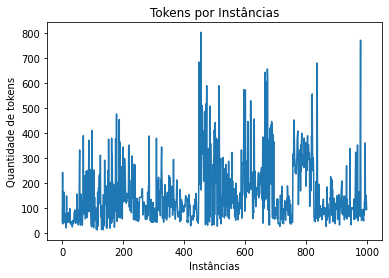

In [64]:
plt.plot([x for x in range(len(lista_tokens_por_inst))], lista_tokens_por_inst)
plt.title("Tokens por Instâncias")
plt.ylabel('Quantidade de tokens')
plt.xlabel('Instâncias')
plt.show()

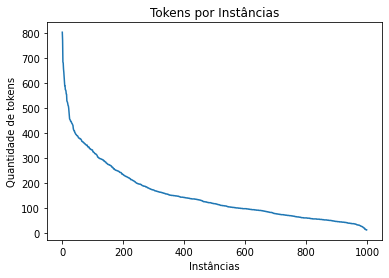

In [65]:
plt.plot([x for x in range(len(lista_tokens_por_inst))], sorted(lista_tokens_por_inst, reverse=True))
plt.title("Tokens por Instâncias")
plt.ylabel('Quantidade de tokens')
plt.xlabel('Instâncias')
plt.show()

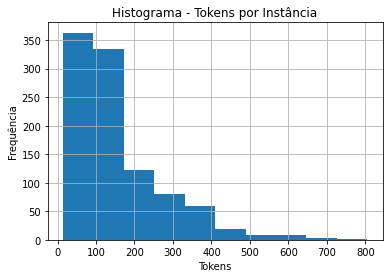

In [66]:
plt.hist(lista_tokens_por_inst)
plt.xlabel('Tokens')
plt.ylabel('Frequência')
plt.title('Histograma - Tokens por Instância')
plt.grid()
plt.show()

### SENTENÇAS POR INSTÂNCIA

In [67]:
print("-----QUANTIDADES-----")
print("Quantidade de instâncias: " + str(len(lista_sentencas_por_inst)))
print("Quantidade de sentenças: " + str(sum(lista_sentencas_por_inst)))
print("Quantidade máxima de sentenças em uma instância: " + str(max(lista_sentencas_por_inst)))
print("Quantidade mínima de sentenças em uma instância: " + str(min(lista_sentencas_por_inst)))
print("-----Médias-----")
print("Média aritmética dos tokens por instância: " + str(statistics.mean(lista_sentencas_por_inst)))
print("Média geométrica dos tokens por instância: " + str(statistics.geometric_mean(lista_sentencas_por_inst)))
print("Média harmônica dos tokens por instância: " + str(statistics.harmonic_mean(lista_sentencas_por_inst)))
print("-----Medianas-----")
print("Mediana dos tokens por instância: " + str(statistics.median(lista_sentencas_por_inst)))
print("Mediana inferior dos tokens por instância: " + str(statistics.median_low(lista_sentencas_por_inst)))
print("Mediana superior dos tokens por instância: " + str(statistics.median_high(lista_sentencas_por_inst)))
print("Mediana, ou o 50º percentil dos dados agrupados dos tokens por instância: " + str(statistics.median_grouped(lista_sentencas_por_inst)))
print("-----Moda-----")
print("Moda dos tokens por instância: " + str(statistics.mode(lista_sentencas_por_inst)))
print("-----Desvio Padrão-----")
print("Desvio padrão populacional dos tokens por instância: " + str(statistics.pstdev(lista_sentencas_por_inst)))
print("Desvio padrão amostral dos tokens por instância: " + str(statistics.stdev(lista_sentencas_por_inst)))
print("-----Variância-----")
print("Variância populacional dos tokens por instância: " + str(statistics.pvariance(lista_sentencas_por_inst)))
print("Variância amostral dos tokens por instância: " + str(statistics.variance(lista_sentencas_por_inst)))
print("-----Quantiles-----")
print("Quantiles dos tokens por instância: " + str(statistics.quantiles(lista_sentencas_por_inst)))

-----QUANTIDADES-----
Quantidade de instâncias: 1000
Quantidade de sentenças: 13615
Quantidade máxima de sentenças em uma instância: 45
Quantidade mínima de sentenças em uma instância: 3
-----Médias-----
Média aritmética dos tokens por instância: 13.615
Média geométrica dos tokens por instância: 11.756979210364026
Média harmônica dos tokens por instância: 10.098261929638852
-----Medianas-----
Mediana dos tokens por instância: 12.0
Mediana inferior dos tokens por instância: 12
Mediana superior dos tokens por instância: 12
Mediana, ou o 50º percentil dos dados agrupados dos tokens por instância: 11.73728813559322
-----Moda-----
Moda dos tokens por instância: 9
-----Desvio Padrão-----
Desvio padrão populacional dos tokens por instância: 7.381380290975394
Desvio padrão amostral dos tokens por instância: 7.385073751447193
-----Variância-----
Variância populacional dos tokens por instância: 54.484775
Variância amostral dos tokens por instância: 54.53931431431431
-----Quantiles-----
Quantiles

#### Gráficos

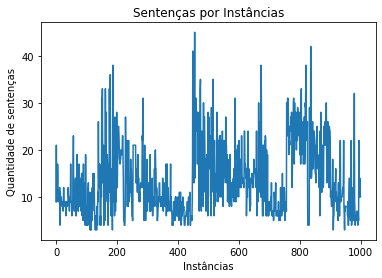

In [68]:
plt.plot([x for x in range(len(lista_sentencas_por_inst))], lista_sentencas_por_inst)
plt.title("Sentenças por Instâncias")
plt.ylabel('Quantidade de sentenças')
plt.xlabel('Instâncias')
plt.show()

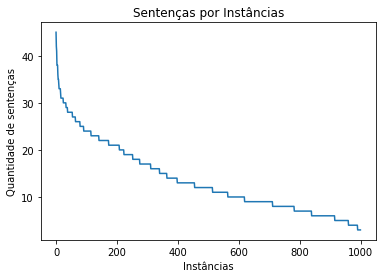

In [69]:
plt.plot([x for x in range(len(lista_sentencas_por_inst))], sorted(lista_sentencas_por_inst, reverse=True))
plt.title("Sentenças por Instâncias")
plt.ylabel('Quantidade de sentenças')
plt.xlabel('Instâncias')
plt.show()

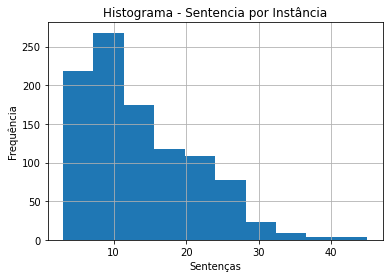

In [70]:
plt.hist(lista_sentencas_por_inst)
plt.xlabel('Sentenças')
plt.ylabel('Frequência')
plt.title('Histograma - Sentencia por Instância')
plt.grid()
plt.show()

# Exemplos / Demonstração

### Cálculo da média com desvio padrão

###### OBS: o cálculo está trabalhando com os valores de tokens por sentença!
O cálculo a seguir irá realizar a seguinte operação:
média + (multiplicador * desvio_padrão)
posteriormente a este cálculo teremos um valor cabeça, e apartir dele iremos quantificar quantas senteças possuem uma quantidade de tokens maiores que o valor cabeça calculado. Tendo em mãos a quantidade de sentenças é calculado a porcetagem que essa quantidade representa ao todo de sentenças.

In [76]:
multiplicador = 1 ## Valor a ser alterado para validar em outros casos
valor = df_limpa.groupby(by="Sentenca")["Palavras"].count().mean() + multiplicador * df_limpa.groupby(by="Sentenca")["Palavras"].count().std()
print("A média mais o desvio padrão vezes " + str(multiplicador) + " resultou no valor: " + str(valor))
resultado = len(list(filter(lambda x : x > valor, list(df_limpa.groupby(by="Sentenca")["Palavras"].count()))))
print("A quantidade de sentenças que possui mais de " + str(valor) + " tokens é de: " + str(resultado))
print("Que representa um total de " + str((resultado / len(df_limpa.groupby(by="Sentenca"))) * 100) + "% das setenças, de um toltal de: " + str(len(df_limpa.groupby(by="Sentenca"))))

A média mais o desvio padrão vezes 1 resultou no valor: 22.42293735341386
A quantidade de sentenças que possui mais de 22.42293735341386 tokens é de: 2056
Que representa um total de 15.100991553433712% das setenças, de um toltal de: 13615


### Imprimindo as setenças que possuem apenas 1 token

In [136]:
## Observação importante: o tamanho de 1 pode ser devido ao fato de que a pontuação que faz parte da senteça foi retirada devido a pedidos

lista_sentenca_com_uma_palavra = []
for dado in df_limpa.groupby(by="Sentenca"):
    if len(dado[1]["Palavras"]) == 1:
        lista_sentenca_com_uma_palavra.append(dado[0])
        print("Na setença: " + str(dado[0]) + " a frase possui apenas 1 palavra, que é: ")
        print(" ".join(dado[1]["Palavras"]))
        cont += 1
print("O total de sentenças com tamanho 1 de palavras são: " + str(len(lista_sentenca_com_uma_palavra)))

Na setença: 1297 a frase possui apenas 1 palavra, que é: 
Experimente
Na setença: 2074 a frase possui apenas 1 palavra, que é: 
Experimente
Na setença: 2286 a frase possui apenas 1 palavra, que é: 
Experimente
Na setença: 3049 a frase possui apenas 1 palavra, que é: 
Confira
Na setença: 3097 a frase possui apenas 1 palavra, que é: 
500ml
Na setença: 4672 a frase possui apenas 1 palavra, que é: 
Saúde
Na setença: 4733 a frase possui apenas 1 palavra, que é: 
Extraordinária
Na setença: 7006 a frase possui apenas 1 palavra, que é: 
Exclusiva
Na setença: 7007 a frase possui apenas 1 palavra, que é: 
Superlativa
Na setença: 7175 a frase possui apenas 1 palavra, que é: 
Local
Na setença: 9998 a frase possui apenas 1 palavra, que é: 
Premium
Na setença: 10161 a frase possui apenas 1 palavra, que é: 
Overpriced
Na setença: 10162 a frase possui apenas 1 palavra, que é: 
Talvez
Na setença: 10164 a frase possui apenas 1 palavra, que é: 
Talvez
Na setença: 10335 a frase possui apenas 1 palavra, qu

O total de sentenças com tamanho 1 de palavras são: 159


#### Para quesitos de comparações das sentenças de tamanho 1 entre o df_original e o df_limpa

In [134]:
## Apenas comparativo não é a recriação da FRASE, visto que para a frase gastaria mais processo

for sentenca in lista_sentenca_com_uma_palavra:
    print("A palavras presentes na sentenca " + str(sentenca) + " são:")
    print("No dataset original (df_original): " + str(" ".join(df_original.loc[df_original["Sentenca"] == sentenca]["Palavras"])))
    print("No dataset modificado (df_limpa): " + str(" ".join(df_limpa.loc[df_limpa["Sentenca"] == sentenca]["Palavras"])))
    print("\n-----------------------------\n")

A palavras presentes na sentenca 1297 são:
No dataset original (df_original): Experimente !
No dataset modificado (df_limpa): Experimente

-----------------------------

A palavras presentes na sentenca 2074 são:
No dataset original (df_original): Experimente !
No dataset modificado (df_limpa): Experimente

-----------------------------

A palavras presentes na sentenca 2286 são:
No dataset original (df_original): Experimente ! !
No dataset modificado (df_limpa): Experimente

-----------------------------

A palavras presentes na sentenca 3049 são:
No dataset original (df_original): Confira
No dataset modificado (df_limpa): Confira

-----------------------------

A palavras presentes na sentenca 3097 são:
No dataset original (df_original): • 500ml .
No dataset modificado (df_limpa): 500ml

-----------------------------

A palavras presentes na sentenca 4672 são:
No dataset original (df_original): Saúde ! !
No dataset modificado (df_limpa): Saúde

-----------------------------

A palavr

No dataset original (df_original): Origem
No dataset modificado (df_limpa): Origem

-----------------------------

A palavras presentes na sentenca 12707 são:
No dataset original (df_original): Madeira
No dataset modificado (df_limpa): Madeira

-----------------------------

A palavras presentes na sentenca 12709 são:
No dataset original (df_original): Tipo
No dataset modificado (df_limpa): Tipo

-----------------------------

A palavras presentes na sentenca 12710 são:
No dataset original (df_original): Origem
No dataset modificado (df_limpa): Origem

-----------------------------

A palavras presentes na sentenca 12733 são:
No dataset original (df_original): Madeira
No dataset modificado (df_limpa): Madeira

-----------------------------

A palavras presentes na sentenca 12750 são:
No dataset original (df_original): Madeira
No dataset modificado (df_limpa): Madeira

-----------------------------

A palavras presentes na sentenca 12751 são:
No dataset original (df_original): Origem
No

No dataset modificado (df_limpa): Tipo

-----------------------------

A palavras presentes na sentenca 13435 são:
No dataset original (df_original): Origem
No dataset modificado (df_limpa): Origem

-----------------------------

A palavras presentes na sentenca 13457 são:
No dataset original (df_original): Tipo
No dataset modificado (df_limpa): Tipo

-----------------------------

A palavras presentes na sentenca 13458 são:
No dataset original (df_original): Origem
No dataset modificado (df_limpa): Origem

-----------------------------

A palavras presentes na sentenca 13476 são:
No dataset original (df_original): Madeira
No dataset modificado (df_limpa): Madeira

-----------------------------

A palavras presentes na sentenca 13478 são:
No dataset original (df_original): Tipo
No dataset modificado (df_limpa): Tipo

-----------------------------

A palavras presentes na sentenca 13479 são:
No dataset original (df_original): Origem
No dataset modificado (df_limpa): Origem

------------

### Verificando as sentenças que foram excluidas do df_original para o df_limpa

In [141]:
## Observação poderia utilizar a lista index_remove que é criada ao percorrer o df_original, porém teria que percorrer o código para obter e isso pode demorar

lista_sentencas_df_limpa = [dado[0] for dado in df_limpa.groupby(by="Sentenca")]
lista_sentencas_df_original = [dado[0] for dado in df_original.groupby(by="Sentenca")]
diferencas_sentencas = sorted(set(lista_sentencas_df_original).difference(lista_sentencas_df_limpa))
for sentenca in diferencas_sentencas:
    print("A sentenca " + str(sentenca) + " foi não está presente no df_limpa, seu conteúdo era: ")
    print(" ".join(df_original.loc[df_original["Sentenca"] == sentenca]["Palavras"]))
    print("\n-----------------------------\n")

A sentenca 1 foi não está presente no df_limpa, seu conteúdo era: 
id : 0

-----------------------------

A sentenca 11 foi não está presente no df_limpa, seu conteúdo era: 
id : 1

-----------------------------

A sentenca 33 foi não está presente no df_limpa, seu conteúdo era: 
id : 2

-----------------------------

A sentenca 43 foi não está presente no df_limpa, seu conteúdo era: 
id : 3

-----------------------------

A sentenca 54 foi não está presente no df_limpa, seu conteúdo era: 
id : 4

-----------------------------

A sentenca 67 foi não está presente no df_limpa, seu conteúdo era: 
id : 5

-----------------------------

A sentenca 85 foi não está presente no df_limpa, seu conteúdo era: 
id : 6

-----------------------------

A sentenca 101 foi não está presente no df_limpa, seu conteúdo era: 
id : 7

-----------------------------

A sentenca 111 foi não está presente no df_limpa, seu conteúdo era: 
id : 8

-----------------------------

A sentenca 121 foi não está presente

A sentenca 1289 foi não está presente no df_limpa, seu conteúdo era: 
id : 124

-----------------------------

A sentenca 1299 foi não está presente no df_limpa, seu conteúdo era: 
id : 125

-----------------------------

A sentenca 1315 foi não está presente no df_limpa, seu conteúdo era: 
id : 126

-----------------------------

A sentenca 1325 foi não está presente no df_limpa, seu conteúdo era: 
id : 127

-----------------------------

A sentenca 1332 foi não está presente no df_limpa, seu conteúdo era: 
id : 128

-----------------------------

A sentenca 1338 foi não está presente no df_limpa, seu conteúdo era: 
id : 129

-----------------------------

A sentenca 1342 foi não está presente no df_limpa, seu conteúdo era: 
id : 130

-----------------------------

A sentenca 1349 foi não está presente no df_limpa, seu conteúdo era: 
id : 131

-----------------------------

A sentenca 1356 foi não está presente no df_limpa, seu conteúdo era: 
id : 132

-----------------------------

A

id : 259

-----------------------------

A sentenca 3438 foi não está presente no df_limpa, seu conteúdo era: 
id : 260

-----------------------------

A sentenca 3460 foi não está presente no df_limpa, seu conteúdo era: 
id : 261

-----------------------------

A sentenca 3482 foi não está presente no df_limpa, seu conteúdo era: 
id : 262

-----------------------------

A sentenca 3496 foi não está presente no df_limpa, seu conteúdo era: 
id : 263

-----------------------------

A sentenca 3510 foi não está presente no df_limpa, seu conteúdo era: 
id : 264

-----------------------------

A sentenca 3524 foi não está presente no df_limpa, seu conteúdo era: 
id : 265

-----------------------------

A sentenca 3539 foi não está presente no df_limpa, seu conteúdo era: 
id : 266

-----------------------------

A sentenca 3556 foi não está presente no df_limpa, seu conteúdo era: 
id : 267

-----------------------------

A sentenca 3568 foi não está presente no df_limpa, seu conteúdo era: 
i

id : 392

-----------------------------

A sentenca 5033 foi não está presente no df_limpa, seu conteúdo era: 
id : 393

-----------------------------

A sentenca 5042 foi não está presente no df_limpa, seu conteúdo era: 
id : 394

-----------------------------

A sentenca 5053 foi não está presente no df_limpa, seu conteúdo era: 
id : 395

-----------------------------

A sentenca 5061 foi não está presente no df_limpa, seu conteúdo era: 
id : 396

-----------------------------

A sentenca 5068 foi não está presente no df_limpa, seu conteúdo era: 
id : 397

-----------------------------

A sentenca 5077 foi não está presente no df_limpa, seu conteúdo era: 
id : 398

-----------------------------

A sentenca 5084 foi não está presente no df_limpa, seu conteúdo era: 
id : 399

-----------------------------

A sentenca 5091 foi não está presente no df_limpa, seu conteúdo era: 
id : 400

-----------------------------

A sentenca 5102 foi não está presente no df_limpa, seu conteúdo era: 
i

id : 466

-----------------------------

A sentenca 5972 foi não está presente no df_limpa, seu conteúdo era: 
id : 467

-----------------------------

A sentenca 5996 foi não está presente no df_limpa, seu conteúdo era: 
id : 468

-----------------------------

A sentenca 6014 foi não está presente no df_limpa, seu conteúdo era: 
id : 469

-----------------------------

A sentenca 6040 foi não está presente no df_limpa, seu conteúdo era: 
id : 470

-----------------------------

A sentenca 6048 foi não está presente no df_limpa, seu conteúdo era: 
id : 471

-----------------------------

A sentenca 6077 foi não está presente no df_limpa, seu conteúdo era: 
id : 472

-----------------------------

A sentenca 6088 foi não está presente no df_limpa, seu conteúdo era: 
id : 473

-----------------------------

A sentenca 6122 foi não está presente no df_limpa, seu conteúdo era: 
id : 474

-----------------------------

A sentenca 6158 foi não está presente no df_limpa, seu conteúdo era: 
i

id : 540

-----------------------------

A sentenca 7353 foi não está presente no df_limpa, seu conteúdo era: 
id : 541

-----------------------------

A sentenca 7368 foi não está presente no df_limpa, seu conteúdo era: 
id : 542

-----------------------------

A sentenca 7379 foi não está presente no df_limpa, seu conteúdo era: 
id : 543

-----------------------------

A sentenca 7399 foi não está presente no df_limpa, seu conteúdo era: 
id : 544

-----------------------------

A sentenca 7422 foi não está presente no df_limpa, seu conteúdo era: 
id : 545

-----------------------------

A sentenca 7436 foi não está presente no df_limpa, seu conteúdo era: 
id : 546

-----------------------------

A sentenca 7461 foi não está presente no df_limpa, seu conteúdo era: 
id : 547

-----------------------------

A sentenca 7471 foi não está presente no df_limpa, seu conteúdo era: 
id : 548

-----------------------------

A sentenca 7480 foi não está presente no df_limpa, seu conteúdo era: 
i

id : 686

-----------------------------

A sentenca 9683 foi não está presente no df_limpa, seu conteúdo era: 
id : 687

-----------------------------

A sentenca 9707 foi não está presente no df_limpa, seu conteúdo era: 
id : 688

-----------------------------

A sentenca 9730 foi não está presente no df_limpa, seu conteúdo era: 
id : 689

-----------------------------

A sentenca 9741 foi não está presente no df_limpa, seu conteúdo era: 
id : 690

-----------------------------

A sentenca 9748 foi não está presente no df_limpa, seu conteúdo era: 
id : 691

-----------------------------

A sentenca 9769 foi não está presente no df_limpa, seu conteúdo era: 
id : 692

-----------------------------

A sentenca 9776 foi não está presente no df_limpa, seu conteúdo era: 
id : 693

-----------------------------

A sentenca 9784 foi não está presente no df_limpa, seu conteúdo era: 
id : 694

-----------------------------

A sentenca 9804 foi não está presente no df_limpa, seu conteúdo era: 
i


A sentenca 10551 foi não está presente no df_limpa, seu conteúdo era: 
id : 764

-----------------------------

A sentenca 10576 foi não está presente no df_limpa, seu conteúdo era: 
id : 765

-----------------------------

A sentenca 10596 foi não está presente no df_limpa, seu conteúdo era: 
id : 766

-----------------------------

A sentenca 10619 foi não está presente no df_limpa, seu conteúdo era: 
id : 767

-----------------------------

A sentenca 10641 foi não está presente no df_limpa, seu conteúdo era: 
id : 768

-----------------------------

A sentenca 10667 foi não está presente no df_limpa, seu conteúdo era: 
id : 769

-----------------------------

A sentenca 10693 foi não está presente no df_limpa, seu conteúdo era: 
id : 770

-----------------------------

A sentenca 10719 foi não está presente no df_limpa, seu conteúdo era: 
id : 771

-----------------------------

A sentenca 10747 foi não está presente no df_limpa, seu conteúdo era: 
id : 772

----------------------

id : 892

-----------------------------

A sentenca 13425 foi não está presente no df_limpa, seu conteúdo era: 
id : 893

-----------------------------

A sentenca 13449 foi não está presente no df_limpa, seu conteúdo era: 
id : 894

-----------------------------

A sentenca 13469 foi não está presente no df_limpa, seu conteúdo era: 
id : 895

-----------------------------

A sentenca 13491 foi não está presente no df_limpa, seu conteúdo era: 
id : 896

-----------------------------

A sentenca 13504 foi não está presente no df_limpa, seu conteúdo era: 
id : 897

-----------------------------

A sentenca 13530 foi não está presente no df_limpa, seu conteúdo era: 
id : 898

-----------------------------

A sentenca 13555 foi não está presente no df_limpa, seu conteúdo era: 
id : 899

-----------------------------

A sentenca 13580 foi não está presente no df_limpa, seu conteúdo era: 
id : 900

-----------------------------

A sentenca 13603 foi não está presente no df_limpa, seu conteúd

# Testes
Experimentação de comandos e realização de operações antes do uso efetivo delas.

### Calculando desvio padrão

In [71]:
print(df_limpa.groupby(by="Sentenca")["Palavras"].count().std())

10.963297250586097


### Calculando moda

In [73]:
print(df_limpa.groupby(by="Sentenca")["Palavras"].count().mode())

0    3
dtype: int64


### Calculando Mediana

In [74]:
print(df_limpa.groupby(by="Sentenca")["Palavras"].count().median())

7.0


In [ ]:
df_teste = df_limpa.loc[0:20]

In [ ]:
display(df_teste)

In [ ]:
print(list(df_teste.groupby(by="Sentenca")["Palavras"].count()))

In [ ]:
print(df_teste.groupby(by="Sentenca")["Palavras"].count().mean())

In [ ]:
print(df_teste.groupby(by="Sentenca")["Palavras"].count().std())

In [ ]:
print(df_limpa.groupby(by="Sentenca")["Palavras"].count().mode())

In [ ]:
print(df_limpa.groupby(by="Sentenca")["Palavras"].count().median())

In [ ]:
import matplotlib.pyplot as plt

plt.hist(lista_setenca_qtdTokens, len(lista_setenca_qtdTokens))

plt.grid(True)
plt.show()

In [ ]:
for dado in df_limpa.groupby(by=["Sentenca"], dropna=False)["Palavras"].count():
    print(dado)

In [ ]:
print(lista_rotulacoes_inst)

In [ ]:
lista_rotulacoes_por_tokens = []
for dado in df_limpa.groupby(by="Palavras"):
    lista_rotulacoes_por_tokens.append([dado[0], list(Counter(list(dado[1]["Rotulo"])).items())])

In [ ]:
print(lista_rotulacoes_por_tokens)

In [ ]:
## Preparando para pegar rotulações por sentença
lista_rotulos_por_sentenca_IOB = []
for dado in df_limpa.groupby(by="Sentenca"):
    lista_rotulos_por_sentenca_IOB.append([dado[0], list(Counter(list(dado[1]["Rotulo"])).items())])

In [ ]:
print(teste)

In [ ]:
print(lista_rotulos_por_sentenca_IOB)

In [44]:
teste = [[x] for x in lista_tokens_por_sentenca]

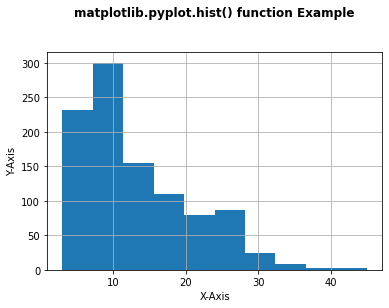

In [40]:
plt.hist(lista_sentencas_por_inst)
plt.xlabel('Sentenças')
plt.ylabel('Frequência')
plt.title('Histograma - Sentencia por Instância')
plt.grid()
plt.show()